In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'INFY.NS'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-05,492.674988,501.500000,489.500000,492.174988,433.750702,9976738
2017-12-06,492.500000,497.049988,492.000000,495.149994,436.372559,7490094
2017-12-07,494.500000,501.450012,492.799988,499.899994,440.558746,7549544
2017-12-08,500.500000,503.500000,497.500000,500.924988,441.462036,5983244
2017-12-11,497.475006,503.450012,496.975006,502.649994,442.982239,5139098


In [6]:
len(data)

1235

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-29,1621.199951,1638.750000,1615.050049,1629.050049,1629.050049,3131710
2022-11-30,1619.949951,1645.750000,1613.150024,1634.949951,1634.949951,11868134
2022-12-01,1656.199951,1672.599976,1652.300049,1657.099976,1657.099976,5407928
2022-12-02,1656.000000,1661.800049,1633.949951,1637.900024,1637.900024,4283343
2022-12-05,1638.000000,1644.849976,1623.300049,1639.750000,1639.750000,3824595


In [8]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

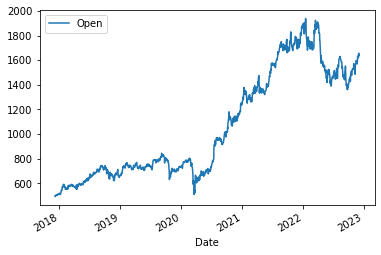

In [9]:
opn.plot()

In [10]:
ds = opn.values

In [11]:
ds

array([[ 492.67498779],
       [ 492.5       ],
       [ 494.5       ],
       ...,
       [1656.19995117],
       [1656.        ],
       [1638.        ]])

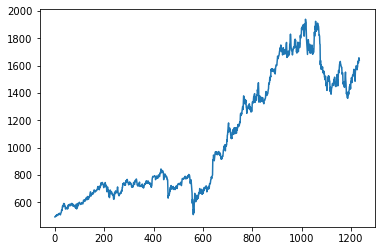

In [12]:
plt.plot(ds)

In [13]:
import numpy as np

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [16]:
len(ds_scaled), len(ds)

(1235, 1235)

In [17]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [18]:
train_size,test_size

(864, 371)

In [19]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [20]:
len(ds_train),len(ds_test)

(864, 371)

In [21]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [22]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [23]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [24]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [25]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [27]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)


Epoch 1/100
12/12 [==============================] - 11s 337ms/step - loss: 0.0222 - val_loss: 0.0820
Epoch 2/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 3/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 4/100
12/12 [==============================] - 2s 170ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 5/100
12/12 [==============================] - 2s 167ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 6/100
12/12 [==============================] - 2s 197ms/step - loss: 9.9515e-04 - val_loss: 0.0035
Epoch 7/100
12/12 [==============================] - 2s 180ms/step - loss: 9.6140e-04 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 2s 180ms/step - loss: 9.5036e-04 - val_loss: 0.0033
Epoch 9/100
12/12 [==============================] - 2s 183ms/step - loss: 9.2707e-04 - val_loss: 0.0033
Epoch 10/100
12/12 [==============================] - 2s 182ms/step - loss

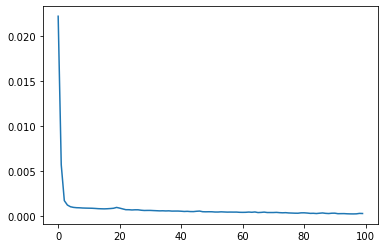

In [29]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [30]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 53ms/step


In [31]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)


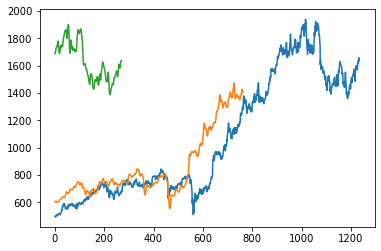

In [32]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)


In [33]:
type(train_predict)


numpy.ndarray

In [34]:
test = np.vstack((train_predict,test_predict))

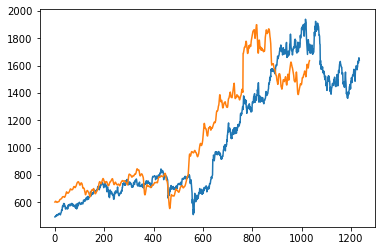

In [35]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)


In [36]:
len(ds_test)


371

In [37]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [38]:
fut_inp = fut_inp.reshape(1,-1)

In [39]:
tmp_inp = list(fut_inp)


In [40]:
fut_inp.shape


(1, 101)

In [41]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [42]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7985761761665344], [0.7977359890937805], [0.7963379621505737], [0.7948675751686096], [0.7935174703598022], [0.7924112677574158], [0.7916386723518372], [0.7912496328353882], [0.7912513017654419], [0.7916152477264404], [0.7922858595848083], [0.7931925058364868], [0.7942585349082947], [0.7954090237617493], [0.7965783476829529], [0.7977132797241211], [0.7987741231918335], [0.7997378706932068], [0.80059415102005], [0.801344633102417], [0.8019993305206299], [0.802574634552002], [0.803089439868927], [0.8035639524459839], [0.8040159344673157], [0.8044599890708923], [0.804908037185669], [0.8053673505783081], [0.8058409094810486], [0.806329071521759]]


In [43]:
len(ds_scaled)

1235

In [44]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [45]:
ds_new = ds_scaled.tolist()

In [46]:
len(ds_new)


1235

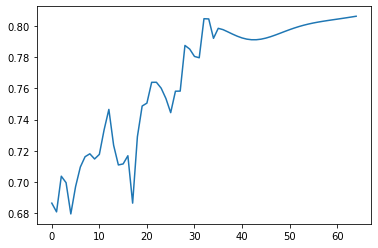

In [47]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])


In [48]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()


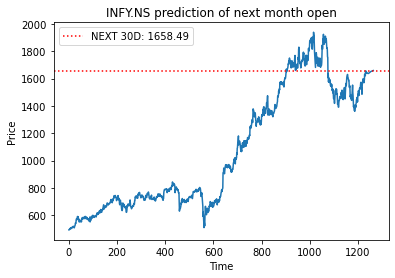

In [49]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [50]:
print(len(final_graph))
for x in range (1225,1265):
    print(final_graph[x]);  #infy

1265
[1569.0]
[1588.9000244140625]
[1589.0000000000002]
[1631.4000244140625]
[1628.0]
[1621.199951171875]
[1619.9499511718752]
[1656.1999511718748]
[1655.9999999999998]
[1638.0]
[1647.2811185385945]
[1646.066165981014]
[1644.0445490515267]
[1641.9182958844613]
[1639.9659767597623]
[1638.3663524325675]
[1637.2491408086062]
[1636.686570196849]
[1636.6889835532347]
[1637.2152676279075]
[1638.185005938445]
[1639.4960617949546]
[1641.0375931862945]
[1642.7012576490088]
[1644.3921585623611]
[1646.033327095909]
[1647.5673598441936]
[1648.9609869656124]
[1650.1992111740547]
[1651.284445825906]
[1652.2311710594804]
[1653.063089482137]
[1653.8075237358134]
[1654.4936926710361]
[1655.1472812950524]
[1655.7894064762368]
[1656.4373064744868]
[1657.10149662834]
[1657.786286502771]
[1658.4921932455763]


In [53]:
final_graph[1264]

[1658.4921932455763]

list